In [1]:
import numpy as np
import scipy.integrate
import sdeint as sdeint

import os
from importlib import reload

from sklearn.decomposition import PCA

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf


import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True) 
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches





In [2]:
def dc_dt(
    c,
    t,
    x,
    derivs_0,
    derivs_L,
    diff_coeff_fun,
    diff_coeff_params,
    rxn_fun,
    rxn_params,
    n_species,
    h,
):
    """
    Time derivative of concentrations in an R-D system 
    for constant flux BCs.
    
    Parameters
    ----------
    c : ndarray, shape (n_species * n_gridpoints)
        The concentration of the chemical species interleaved in a
        a NumPy array.  The interleaving allows us to take advantage 
        of the banded structure of the Jacobian when using the 
        Hindmarsh algorithm for integrating in time.
    t : float
        Time.
    derivs_0 : ndarray, shape (n_species)
        derivs_0[i] is the value of the diffusive flux,
        D dc_i/dx, at x = 0, the leftmost boundary of the domain of x.
    derivs_L : ndarray, shape (n_species)
        derivs_0[i] is the value of the diffusive flux,
        D dc_i/dx, at x = L, the rightmost boundary of the domain of x.
    diff_coeff_fun : function
        Function of the form diff_coeff_fun(c_tuple, t, x, *diff_coeff_params).
        Returns an tuple where entry i is a NumPy array containing
        the diffusion coefficient of species i at the grid points.
        c_tuple[i] is a NumPy array containing the concentrations of
        species i at the grid poitns.
    diff_coeff_params : arbitrary
        Tuple of parameters to be passed into diff_coeff_fun.
    rxn_fun : function
        Function of the form rxn_fun(c_tuple, t, *rxn_params).
        Returns an tuple where entry i is a NumPy array containing
        the net rate of production of species i by chemical reaction
        at the grid points.  c_tuple[i] is a NumPy array containing 
        the concentrations of species i at the grid poitns.
    rxn_params : arbitrary
        Tuple of parameters to be passed into rxn_fun.
    n_species : int
        Number of chemical species.
    h : float
        Grid spacing (assumed to be constant)
        
    Returns
    -------
    dc_dt : ndarray, shape (n_species * n_gridpoints)
        The time derivatives of the concentrations of the chemical
        species at the grid points interleaved in a NumPy array.
    """
    # Tuple of concentrations
    c_tuple = tuple([c[i::n_species] for i in range(n_species)])

    # Compute diffusion coefficients
    D_tuple = diff_coeff_fun(c_tuple, t, x, *diff_coeff_params)

    # Compute reaction terms
    rxn_tuple = rxn_fun(c_tuple, t, *rxn_params)

    # Return array
    conc_deriv = np.empty_like(c)

    # Convenient array for storing concentrations
    da_dt = np.empty(len(c_tuple[0]))

    # Useful to have square of grid spacing around
    h2 = h ** 2

    # Compute diffusion terms (central differencing w/ Neumann BCs)
    for i in range(n_species):
        # View of concentrations and diffusion coeff. for convenience
        a = np.copy(c_tuple[i])
        D = np.copy(D_tuple[i])

        # Time derivative at left boundary
        da_dt[0] = D[0] / h2 * 2 * (a[1] - a[0] - h * derivs_0[i])

        # First derivatives of D and a
        dD_dx = (D[2:] - D[:-2]) / (2 * h)
        da_dx = (a[2:] - a[:-2]) / (2 * h)

        # Time derivative for middle grid points
        da_dt[1:-1] = D[1:-1] * np.diff(a, 2) / h2 + dD_dx * da_dx

        # Time derivative at left boundary
        da_dt[-1] = D[-1] / h2 * 2 * (a[-2] - a[-1] + h * derivs_L[i])

        # Store in output array with reaction terms
        conc_deriv[i::n_species] = da_dt + rxn_tuple[i]

    return conc_deriv


def rd_solve(
    c_0_tuple,
    t,
    L=1,
    derivs_0=0,
    derivs_L=0,
    diff_coeff_fun=None,
    diff_coeff_params=(),
    rxn_fun=None,
    rxn_params=(),
    rtol=1.49012e-8,
    atol=1.49012e-8,
):
    """
    Parameters
    ----------
    c_0_tuple : tuple
        c_0_tuple[i] is a NumPy array of length n_gridpoints with the 
        initial concentrations of chemical species i at the grid points.
    t : ndarray
        An array of time points for which the solution is desired.
    L : float
        Total length of the x-domain.
    derivs_0 : ndarray, shape (n_species)
        derivs_0[i] is the value of dc_i/dx at x = 0.
    derivs_L : ndarray, shape (n_species)
        derivs_L[i] is the value of dc_i/dx at x = L, the rightmost
        boundary of the domain of x.
    diff_coeff_fun : function
        Function of the form diff_coeff_fun(c_tuple, x, t, *diff_coeff_params).
        Returns an tuple where entry i is a NumPy array containing
        the diffusion coefficient of species i at the grid points.
        c_tuple[i] is a NumPy array containing the concentrations of
        species i at the grid poitns.
    diff_coeff_params : arbitrary
        Tuple of parameters to be passed into diff_coeff_fun.
    rxn_fun : function
        Function of the form rxn_fun(c_tuple, t, *rxn_params).
        Returns an tuple where entry i is a NumPy array containing
        the net rate of production of species i by chemical reaction
        at the grid points.  c_tuple[i] is a NumPy array containing 
        the concentrations of species i at the grid poitns.
    rxn_params : arbitrary
        Tuple of parameters to be passed into rxn_fun.
    rtol : float
        Relative tolerance for solver.  Default os odeint's default.
    atol : float
        Absolute tolerance for solver.  Default os odeint's default.
        
    Returns
    -------
    c_tuple : tuple
        c_tuple[i] is a NumPy array of shape (len(t), n_gridpoints)
        with the initial concentrations of chemical species i at 
        the grid points over time.
        
    Notes
    -----
    .. When intergrating for long times near a steady state, you
       may need to lower the absolute tolerance (atol) because the
       solution does not change much over time and it may be difficult
       for the solver to maintain tight tolerances.
    """
    # Number of grid points
    n_gridpoints = len(c_0_tuple[0])

    # Number of chemical species
    n_species = len(c_0_tuple)

    # Grid spacing
    h = L / (n_gridpoints - 1)

    # Grid points
    x = np.linspace(0, L, n_gridpoints)

    # Set up boundary conditions
    if np.isscalar(derivs_0):
        derivs_0 = np.array(n_species * [derivs_0])
    if np.isscalar(derivs_L):
        derivs_L = np.array(n_species * [derivs_L])

    # Set up parameters to be passed in to dc_dt
    params = (
        x,
        derivs_0,
        derivs_L,
        diff_coeff_fun,
        diff_coeff_params,
        rxn_fun,
        rxn_params,
        n_species,
        h,
    )

    # Set up initial condition
    c0 = np.empty(n_species * n_gridpoints)
    for i in range(n_species):
        c0[i::n_species] = c_0_tuple[i]

    # Solve using odeint, taking advantage of banded structure
    c = scipy.integrate.odeint(
        dc_dt,
        c0,
        t,
        args=params,
        ml=n_species,
        mu=n_species,
        rtol=rtol,
        atol=atol,
    )

    return np.array([c[:, i::n_species] for i in range(n_species)])

def constant_diff_coeffs(c_tuple, t, x, diff_coeffs):
    n = len(c_tuple[0])
    return tuple([diff_coeffs[i] * np.ones(n) for i in range(len(c_tuple))])


def asdm_rxn(as_tuple, t, mu):
    """
    Reaction expression for activator-substrate depletion model.

    Returns the rate of production of activator and substrate, respectively.

    r_a = a**2 * s - a
    r_s = mu * (1 - a**2 * s)
    """
    # Unpack concentrations
    a, s = as_tuple

    # Compute and return reaction rates
    a2s = a ** 2 * s
    return (a2s - a, mu * (1.0 - a2s))

def dispersion_relation(k_vals, d, mu):
    lam = np.empty_like(k_vals)
    for i, k in enumerate(k_vals):
        A = np.array([[1-d*k**2,          1],
                      [-2*mu,    -mu - k**2]])
        lam[i] = np.linalg.eigvals(A).real.max()
        
    return lam

def dispersion_eig(k_vals, d, mu):
    lam = np.zeros((k_vals.shape[0],2))
    evec = np.zeros((k_vals.shape[0],2,2))
    for i, k in enumerate(k_vals):
        A = np.array([[1-d*k**2,          1],
                      [-2*mu,    -mu - k**2]])
        w,v = np.linalg.eig(A)
        lam[i] = w.real
        evec[i] = np.abs(v)
        
    return lam, evec

lmax = lambda m: (1+1/np.sqrt(np.divide(*m.shape)))**2 # max likely correlation eigenvalue from random data

def sinkhorn(A, max_iter=1000, err=1e-4, out_iter = 10):
    c,r = np.shape(A)
    x = np.ones(c)
    y = np.ones(r)
    for i in range(max_iter):
        delr = np.amax(np.abs(x*(A@y)-r))
        delc = np.amax(np.abs(y*(A.T@x)-c))
        
        if i>0 and i%out_iter == 0:
            print('''i = {0}: 
                delr = {1}, delc = {2}
                <x> = {3}, <y> = {4}'''.format(i, delr, delc, np.mean(x), np.mean(y)))
        
        if np.isnan(delr) or np.isnan(delc):
            return x,y, False
        
        if delr < err and delc < err:
            return x,y, True
        
        y = c / (A.T@x)
        x = r / (A@y)
    return x, y, False

def sinkhorn_norm(A, max_iter=1000, err=1e-4, out_iter = 10):
    usq,vsq,_=sinkhorn(A, max_iter, err, out_iter)
    return np.diag(usq)@A@np.diag(vsq)

In [3]:
# def euler(c, dcdt, nt, dt, noise_scale):
#     for i in range(nt):
#         c = c + dcdt(c)*dt + noise_scale*np.sqrt(dt)*np.sqrt

def rd_solve_ito(
    c_0_tuple,
    dt,
    tmax,
    noise_scale = 1,
    L=1,
    derivs_0=0,
    derivs_L=0,
    diff_coeff_fun=None,
    diff_coeff_params=(),
    rxn_fun=None,
    rxn_params=(),
    rtol=1.49012e-8,
    atol=1.49012e-8,
):
    """
    Parameters
    ----------
    c_0_tuple : tuple
        c_0_tuple[i] is a NumPy array of length n_gridpoints with the 
        initial concentrations of chemical species i at the grid points.
    t : ndarray
        An array of time points for which the solution is desired.
    L : float
        Total length of the x-domain.
    derivs_0 : ndarray, shape (n_species)
        derivs_0[i] is the value of dc_i/dx at x = 0.
    derivs_L : ndarray, shape (n_species)
        derivs_L[i] is the value of dc_i/dx at x = L, the rightmost
        boundary of the domain of x.
    diff_coeff_fun : function
        Function of the form diff_coeff_fun(c_tuple, x, t, *diff_coeff_params).
        Returns an tuple where entry i is a NumPy array containing
        the diffusion coefficient of species i at the grid points.
        c_tuple[i] is a NumPy array containing the concentrations of
        species i at the grid poitns.
    diff_coeff_params : arbitrary
        Tuple of parameters to be passed into diff_coeff_fun.
    rxn_fun : function
        Function of the form rxn_fun(c_tuple, t, *rxn_params).
        Returns an tuple where entry i is a NumPy array containing
        the net rate of production of species i by chemical reaction
        at the grid points.  c_tuple[i] is a NumPy array containing 
        the concentrations of species i at the grid poitns.
    rxn_params : arbitrary
        Tuple of parameters to be passed into rxn_fun.
    rtol : float
        Relative tolerance for solver.  Default os odeint's default.
    atol : float
        Absolute tolerance for solver.  Default os odeint's default.
        
    Returns
    -------
    c_tuple : tuple
        c_tuple[i] is a NumPy array of shape (len(t), n_gridpoints)
        with the initial concentrations of chemical species i at 
        the grid points over time.
        
    Notes
    -----
    .. When intergrating for long times near a steady state, you
       may need to lower the absolute tolerance (atol) because the
       solution does not change much over time and it may be difficult
       for the solver to maintain tight tolerances.
    """
    # Number of grid points
    n_gridpoints = len(c_0_tuple[0])

    # Number of chemical species
    n_species = len(c_0_tuple)

    # Grid spacing
    h = L / (n_gridpoints - 1)

    # Grid points
    x = np.linspace(0, L, n_gridpoints)

    # Set up boundary conditions
    if np.isscalar(derivs_0):
        derivs_0 = np.array(n_species * [derivs_0])
    if np.isscalar(derivs_L):
        derivs_L = np.array(n_species * [derivs_L])

    # Set up initial condition
    c0 = np.empty(n_species * n_gridpoints)
    for i in range(n_species):
        c0[i::n_species] = c_0_tuple[i]

    # Solve using odeint, taking advantage of banded structure
    dc_dt_simple = lambda c, t: dc_dt(c, t, x, derivs_0, derivs_L, diff_coeff_fun, diff_coeff_params,
                                      rxn_fun,rxn_params,n_species,h)
    noise_func   = lambda c,t: noise_scale*np.sqrt(h)*np.sqrt(dt)*np.ones((n_species * n_gridpoints, 1))
    c = sdeint.itoEuler(
        dc_dt_simple,
        noise_func,
        c0,
        np.arange(0,tmax+dt, dt),
    )

    return np.array([c[:, i::n_species] for i in range(n_species)])

In [4]:
# Set up steady state (using 500 grid points)
a_0 = np.ones(500)
s_0 = np.ones(500)

# Make a small perturbation to a_0
a_0 += 0.01 * np.random.rand(len(a_0))

# Time points
#t = np.linspace(0.0, 1000.0, 1000)
dt = 0.001
tmax = 100
t  = np.arange(0,tmax+dt,dt)

# Physical length of system
L = 20.0

# x-coordinates for plotting
x = np.linspace(0, L, len(a_0))

# Diffusion coefficients
diff_coeffs   = (0.05, 1.0)
#diff_coeffs_a = 0.001*np.hstack([np.arange(1,10), np.arange(10,100,10),np.arange(100,1100,100)])


# Reaction parameter (must be a tuple of params, even though only 1 for ASDM)
rxn_params = (1.5,)

# Solve
conc = np.array(rd_solve(
    (a_0, s_0),
    t,
    L=L,
    derivs_0=0,
    derivs_L=0,
    diff_coeff_fun=constant_diff_coeffs,
    diff_coeff_params=(diff_coeffs,),
    rxn_fun=asdm_rxn,
    rxn_params=rxn_params,
))

In [5]:
print(sdeint.itoEuler.__doc__)

Use the Euler-Maruyama algorithm to integrate the Ito equation
    dy = f(y,t)dt + G(y,t) dW(t)

    where y is the d-dimensional state vector, f is a vector-valued function,
    G is an d x m matrix-valued function giving the noise coefficients and
    dW(t) = (dW_1, dW_2, ... dW_m) is a vector of independent Wiener increments

    Args:
      f: callable(y, t) returning (d,) array
         Vector-valued function to define the deterministic part of the system
      G: callable(y, t) returning (d,m) array
         Matrix-valued function to define the noise coefficients of the system
      y0: array of shape (d,) giving the initial state vector y(t==0)
      tspan (array): The sequence of time points for which to solve for y.
        These must be equally spaced, e.g. np.arange(0,10,0.005)
        tspan[0] is the intial time corresponding to the initial state y0.
      dW: optional array of shape (len(tspan)-1, d). This is for advanced use,
        if you want to use a specific realizat

In [6]:
dt = 5e-4;
tmax = 40;
noise_scale = 10;
conc2 = np.array(rd_solve_ito(
    (a_0, s_0,),
    dt,
    tmax,
    noise_scale,
    L=L,
    derivs_0=0,
    derivs_L=0,
    diff_coeff_fun=constant_diff_coeffs,
    diff_coeff_params=(diff_coeffs,),
    rxn_fun=asdm_rxn,
    rxn_params=rxn_params,
))

In [7]:
# conc = np.array(rd_solve_ito((a_0, s_0,), dt, tmax, noise_scale, L=L,derivs_0=0,derivs_L=0,
#                                     diff_coeff_fun=constant_diff_coeffs,diff_coeff_params=(diff_coeffs,),
#                                     rxn_fun=asdm_rxn,rxn_params=rxn_params,))[:]
# #11 s... need ~30 diffusion coeffs, ~50 replicates ==> 15000 second ==> 4 hrs ?

In [8]:
#diff_coeffs_a

In [9]:
# conc0 = np.array(rd_solve_ito(
#     (a_0, s_0,),
#     dt,
#     tmax,
#     0,
#     L=L,
#     derivs_0=0,
#     derivs_L=0,
#     diff_coeff_fun=constant_diff_coeffs,
#     diff_coeff_params=(diff_coeffs,),
#     rxn_fun=asdm_rxn,
#     rxn_params=rxn_params,
# ))

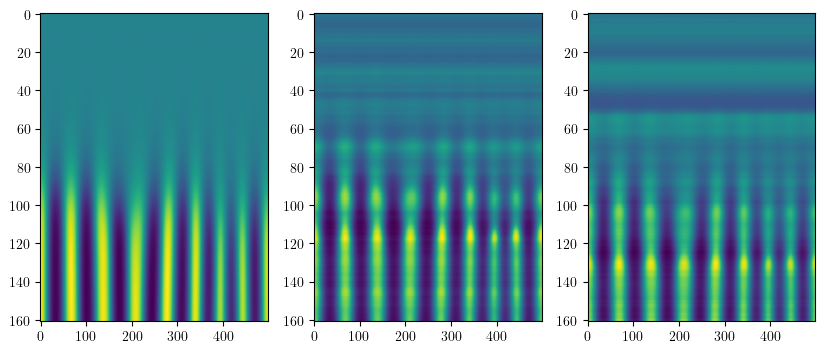

In [59]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
axs[0].imshow(conc0[0,::500],aspect='auto')
axs[1].imshow(conc2[0,::500],aspect='auto')
axs[2].imshow(conc3[0,::500],aspect='auto')


plt.show()

In [211]:
da_kbin_evecs = np.array([[[PCA().fit(da_kbin[k][s,i]).components_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])

In [212]:
da_kbin_evals = np.array([[[PCA().fit(da_kbin[k][s,i]).explained_variance_ 
                            for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])


In [213]:
da_kbin_eval_rat = np.array([[[PCA().fit(da_kbin[k][s,i]).explained_variance_ratio_ 
                            for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])


In [215]:
da_kbin_evals_mu = np.mean(da_kbin_evals,axis=2)

In [20]:
ncomp = np.array([x.shape[2] for x in da_kbin])

In [217]:
#da_kbin_evals_mu.shape, diff_coeffs_a.shape

In [19]:
kvals     = np.pi * ngrid / (lscales * L)
disps     = np.array([dispersion_relation(kvals, d, rxn_params[0]) for d in diff_rats])
disp_pca  = [dispersion_eig(kvals, d, rxn_params[0]) for d in diff_rats]

disp_eig  = np.array([d[0] for d in disp_pca])
disp_evec = np.array([d[1] for d in disp_pca])


disp_max_eig_idx = np.argmax(disp_eig, axis=2)
disp_max_eig     = np.amax(disp_eig, axis=2)
disp_max_evec    = np.array([[disp_evec[i,j,:,disp_max_eig_idx[i,j]] for j in range(disp_evec.shape[1])] 
                     for i in range(disp_evec.shape[0])]).transpose((1,0,2))
has_pattern      = np.amax(1/disps, axis=1)>0

In [21]:
da_kbin_max_evec = da_kbin_evecs[:,:,:,0]
#da_kbin_evec_mu  = np.mean(da_kbin_max_evec,axis=2)
evec_errs        = np.linalg.norm(da_kbin_max_evec.transpose((2,0,1,3)) - disp_max_evec,axis=3)
evec_err_mu      = np.mean(evec_errs,axis=0)

In [220]:
disp_max_evec.shape, da_kbin_max_evec.shape

((19, 27, 2), (19, 27, 20, 2))

In [221]:
ncomp

array([498, 497, 496, 495, 494, 493, 492, 491, 490, 480, 470, 460, 450,
       440, 430, 420, 410, 400, 300])

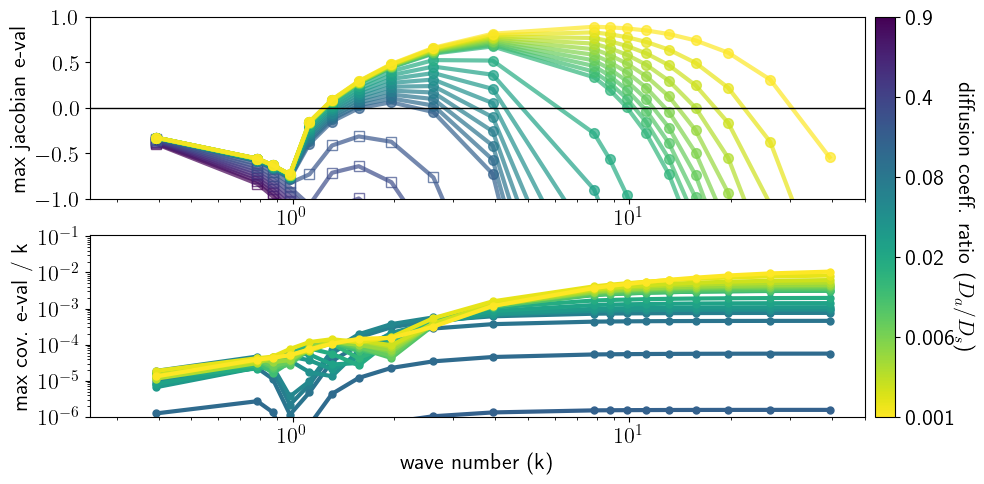

In [226]:
fig,axs = plt.subplots(2,1,figsize=(10,5))
cols    = plt.cm.viridis_r(np.linspace(0,1,ndiff))
my_cmap = plt.cm.viridis_r
marks   = ['o' if has_pattern[i] else 's' for i in range(ndiff)]
fills   = ['full' if has_pattern[i] else 'none' for i in range(ndiff)]
msizes  = [5 if has_pattern[i] else 2*(ndiff - i) for i in range(ndiff)]
for i in range(ndiff-1,-1,-1):
    
    
    axs[0].plot(kvals, disp_max_eig[i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=0.7, markersize=7, lw=3)
    axs[1].plot(kvals, da_kbin_evals_mu[:,i,0]/ncomp, '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=msizes[i], lw=3)
#     axs[1].plot(kvals, da_kbin_evals_mu[:,i,0], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
#          alpha=0.7, markersize=msizes[i], lw=3)

#     axs[1].plot(kvalsp, evar0_pattern_binned[:,i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
#              alpha=1, markersize=msizes[i], lw=3)

for ax in axs:
    ax.set_xscale('log')
#axs[0].set_yscale('symlog')
#axs[1].set_yscale('symlog',linthresh=0.1)
#axs[1].set_ylim(-0.01,400)
#axs[1].set_yscale('symlog', linthresh=1e-3)
#axs[1].set_ylim(ymin=-1e-5)

axs[1].set_yscale('log')
axs[1].set_ylim(ymin=1e-6)

#axs[1].plot(kvalsp, 10*kvalsp**1.5,'--', color = 'black', label = r'$\sim k^{2}$', lw=4, alpha =0.7)
#axs[1].plot(kvalsp, 0.3*kvalsp, '--', color = 'cyan', label = r'$\sim k^{1}$', lw = 4, alpha = 0.7)


#axs[1].legend(fontsize=16)

axs[1].set_xlabel('wave number (k)')
axs[0].set_ylabel(r'max jacobian e-val')
axs[1].set_ylabel(r'max cov. e-val / k')
#axs[1].set_xlim()

axs[0].set_ylim(-1, 1)


axs[0].axhline(0,color='k',lw=1)
for ax in axs: #[axs[0], axs[1], cax]
    ax.set_xlim(0.25,50)
    mf.set_axs_fontsize(ax, 16)
    
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.91, 0.1, 0.02, 0.8])
cbar = plt.colorbar(sm, cax=cax)
ctix = np.linspace(0,1,6)
cbar.set_ticks(ctix)
cbar.set_ticklabels(np.hstack([diff_rats[np.array(ctix[0:-1]*ndiff, dtype='int')], diff_rats[-1]]))
cbar.set_label(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 270, labelpad = 15)

# cax.set_yticks(np.linspace(0,1,6))
# cax.set_yticklabels(np.hstack([diff_rats[np.array(ctix[0:-1]*ndiff, dtype='int')],
#                                diff_rats[-1]]))
# cax.set_ylabel(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 270, labelpad = 15)
mf.set_axs_fontsize(cax, 16)
plt.show()


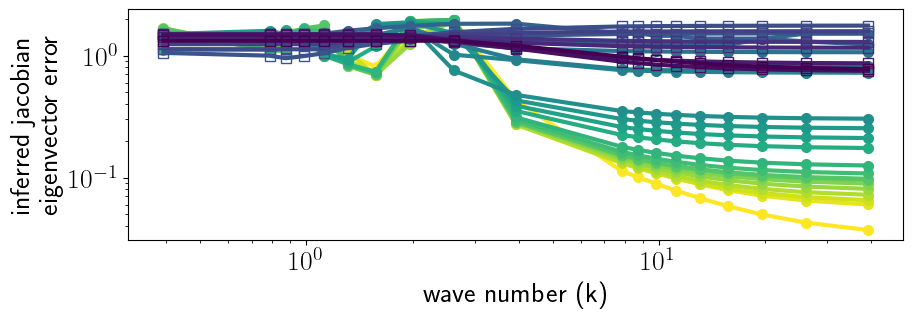

In [223]:
fig,axs=plt.subplots(1,1,figsize=(10,3))
cols = plt.cm.viridis_r(np.linspace(0,1,ndiff))
my_cmap = plt.cm.viridis_r
marks = ['o' if has_pattern[i] else 's' for i in range(ndiff)]
fills=['full' if has_pattern[i] else 'none' for i in range(ndiff)]
msizes = [5 if has_pattern[i] else 2*(ndiff - i) for i in range(ndiff)]

for i in range(ndiff):
    
    axs.plot(kvals, evec_err_mu[:,i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=7, lw=3)
axs.set_xscale('log')
axs.set_yscale('log')
mf.set_axs_fontsize(axs,20)
axs.set_xlabel('wave number (k)')
axs.set_ylabel('inferred jacobian\n eigenvector error')
plt.show()

In [224]:
# da_kbin = [np.array([[[np.mean(pattern_tf[s,j,:,k:k+w], axis=1) for k in np.arange(0,ngrid-w,int(w/2))]
#                       for j in range(nrep)]
#                      for s in range(ndiff)]) 
#            for w in lscales]
k = 0
s = 0
i = 0
da_kbin[k][s,i].shape


(498, 2)

In [233]:
usq, vsq,_ = sinkhorn(da_kbin[k][s,i], max_iter = 100, err=1e-100)

i = 0: 
                delr = 8.857225728072926, delc = 331.03233195385315
                <x> = 1.0, <y> = 1.0
i = 10: 
                delr = 2.220446049250313e-16, delc = 0.17939401679677758
                <x> = 2.4011122357606363, <y> = 2.5556591274869636
i = 20: 
                delr = 2.220446049250313e-16, delc = 1.8225858070763934e-05
                <x> = 2.4015937426644944, <y> = 2.556525446897746
i = 30: 
                delr = 2.220446049250313e-16, delc = 1.8508785615267698e-09
                <x> = 2.4015937915723793, <y> = 2.556525534926708


In [3]:
diff_rats = np.hstack([0.001*np.arange(1,10),0.01*np.arange(1,10), 0.1*np.arange(1,10)])
reps = np.arange(20)
datdir = '/Users/simonfreedman/data/droso/turing/noise_scales/noise10'

pattern_tf = np.array([[np.load('{0}/diff{1:.3f}_samp{2}.npy'.format(datdir, diff_rats[i], reps[j]))[:,-1] 
                        for j in range(len(reps))]
                       for i in range(len(diff_rats))])

In [4]:
ndiff, nrep, ng, ngrid = pattern_tf.shape
lscales = np.hstack([np.arange(2,10), np.arange(10,100,10),np.arange(100,300,100)])
skip    = 1 # int(w/2)
da_kbin = [np.array([[[np.mean(pattern_tf[s,j,:,k:k+w], axis=1) for k in np.arange(0,ngrid-w,w)]
                      for j in range(nrep)]
                     for s in range(ndiff)]) 
           for w in lscales]
ncomp = np.array([x.shape[2] for x in da_kbin])

#[x.shape for x in da_kbin]
# da_kbin[i][j,k,l,m] is the i^th length scale
#                        the j^th diffusion ratio (or distance from MF)
#                        the k^th replicate
#                        the l^th bin
#                        the m^th gene avgd over every position in the bin

In [5]:
# # same number of bins at every kscale
# nbin    = 10  
# da_kbins = [np.array([[[pattern_tf[s,j,:,k:k+w] for k in np.arange(0,ngrid-w,1)] 
#               for j in range(nrep)]
#              for s in range(ndiff)])
#             for w in lscales]

# [x.shape for x in da_kbins] 
# da_kbins[i][j,k,l,m,n] is the i^th length scale
#                           the j^th diffusion ratio (or distance from MF)
#                           the k^th replicate
#                           the l^th bin
#                           the m^th gene
#                           the n^th position along the bin

In [6]:
nlscale = len(lscales)
ngene = 2

In [8]:
samp_size = 100
nsamp     = 15

samp_idxs = [np.random.choice(ncomp[i], size = [ndiff, nrep, nsamp, samp_size],replace=True) 
             for i in range(len(lscales))]
kbin_samps = np.array([[[da_kbin[i][j,k,samp_idxs[i][j,k]] for k in range(nrep)]
                        for j in range(ndiff)]
                       for i in range(nlscale)])
# kbin_samps.shape

# kbin_samps[i,j,k,l,m,n] is the i^th length scale
#                            the j^th diffusion ratio (distance from MF)
#                            the k^th replicate
#                            the l^th sample
#                            the m^th sample of the sample
#                            the n^th gene


In [9]:
# flatten along k / l

kbin_samps_f = kbin_samps.reshape((nlscale,ndiff, nrep*nsamp, samp_size, ngene))
# kbin_samps_f.shape


# kbin_samps_f[i,j,k,l,m] is the i^th length scale
#                            the j^th diffusion ratio (distance from MF)
#                            the k^th sample
#                            the l^th sample of the sample
#                            the m^th gene

nrepsamp = nrep*nsamp

In [10]:
# to test reshaping....
# i = 0
# j = 0
# np.array_equal(kbin_samps_f[i,j,16], kbin_samps[i,j,1,1])
# np.sum(~np.array([[[[np.array_equal(kbin_samps_f[i,j,k*nsamp+l], kbin_samps[i,j,k,l]) 
#               for l in range(nsamp)] 
#              for k in range(nrep)]
#             for j in range(ndiff)]
#            for i in range(nlscale)])) # should be 0

In [11]:
# kbin_pcas = np.array([[[PCA().fit(kbin_samps_f[i,j,k]) 
#                         for k in range(nrepsamp)] 
#                        for j in range(ndiff)]
#                       for i in range(len(lscales))])
kbin_pcas = np.array([[[PCA().fit(da_kbin[k][s,i]) for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])

In [12]:

da_kbin_evecs = np.array([[[kbin_pcas[k,s,i].components_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])
da_kbin_evals = np.array([[[kbin_pcas[k,s,i].explained_variance_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])
da_kbin_eval_rats = np.array([[[kbin_pcas[k,s,i].explained_variance_ratio_ for i in range(nrep)] for s in range(ndiff)]
                        for k in range(len(lscales))])


In [13]:
# da_kbin_norms = [np.array([[sinkhorn_norm(da_kbin[k][s,i], max_iter = 100, err=1e-100, out_iter=100) 
#                  for i in np.arange(da_kbin[k].shape[1])]
#                  for s in np.arange(da_kbin[k].shape[0])])
#                  for k in np.arange(len(lscales))]

In [14]:
# kbin_pcas = np.array([[[PCA().fit(da_kbin_norms[k][s,i]) for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_evecs = np.array([[[kbin_pcas[k,s,i].components_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_evals = np.array([[[kbin_pcas[k,s,i].explained_variance_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])
# da_kbin_eval_rats = np.array([[[kbin_pcas[k,s,i].explained_variance_ratio_ for i in range(nrep)] for s in range(ndiff)]
#                         for k in range(len(lscales))])


In [19]:
L = 20.0
kvals     = np.pi * ngrid / (lscales * L)
rxn_params = (1.5,)

disps     = np.array([dispersion_relation(kvals, d, rxn_params[0]) for d in diff_rats])
disp_pca  = [dispersion_eig(kvals, d, rxn_params[0]) for d in diff_rats]

disp_eig  = np.array([d[0] for d in disp_pca])
disp_evec = np.array([d[1] for d in disp_pca])


disp_max_eig_idx = np.argmax(disp_eig, axis=2)
disp_max_eig     = np.amax(disp_eig, axis=2)
disp_max_evec    = np.array([[disp_evec[i,j,:,disp_max_eig_idx[i,j]] for j in range(disp_evec.shape[1])] 
                     for i in range(disp_evec.shape[0])]).transpose((1,0,2))
has_pattern      = np.amax(1/disps, axis=1)>0

In [20]:
da_kbin_evals_mu = np.mean(da_kbin_evals,axis=2)
da_kbin_max_evec = da_kbin_evecs[:,:,:,0]
#da_kbin_evec_mu  = np.mean(da_kbin_max_evec,axis=2)
evec_errs        = np.linalg.norm(da_kbin_max_evec.transpose((2,0,1,3)) - disp_max_evec,axis=3)
evec_err_mu      = np.mean(evec_errs,axis=0)

In [21]:
pattern_k = kvals[np.array([np.argmax(x) for x in disp_max_eig])]

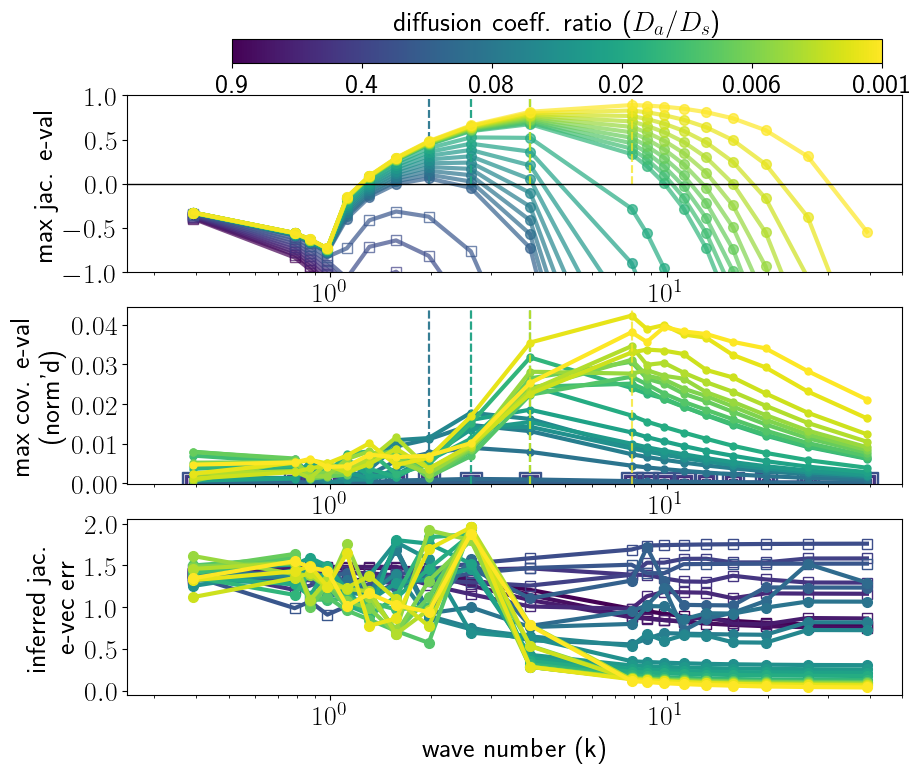

In [26]:
fig,axs = plt.subplots(3,1,figsize=(10,8))
cols    = plt.cm.viridis_r(np.linspace(0,1,ndiff))
marks   = ['o' if has_pattern[i] else 's' for i in range(ndiff)]
fills   = ['full' if has_pattern[i] else 'none' for i in range(ndiff)]
msizes  = [5 if has_pattern[i] else 2*(ndiff - i) for i in range(ndiff)]

norm = 1/ncomp #np.ones_like(ncomp) #ncomp
for i in range(ndiff-1,-1,-1):
    
    
    axs[0].plot(kvals, disp_max_eig[i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=0.7, markersize=7, lw=3)
    axs[1].plot(kvals, da_kbin_evals_mu[:,i,0]*norm, '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=msizes[i], lw=3)
    axs[2].plot(kvals, evec_err_mu[:,i], '-', color=cols[i], marker=marks[i], fillstyle=fills[i], 
             alpha=1, markersize=7, lw=3)
    
    if has_pattern[i]:
        axs[0].axvline(pattern_k[i], ymin=0.5,color=cols[i], linestyle='--', alpha=0.5)
        axs[1].axvline(pattern_k[i], ymin=0,color=cols[i], linestyle='--', alpha=0.5)
    
for ax in axs:
    ax.set_xscale('log')

#axs[1].set_yscale('symlog',linthresh=1e-3)
axs[1].set_ylim(ymin=-1e-4)


axs[2].set_xlabel('wave number (k)')
axs[0].set_ylabel('max jac. e-val')
axs[1].set_ylabel('max cov. e-val\n(norm\'d)')
axs[2].set_ylabel('inferred jac.\ne-vec err')
axs[0].set_ylim(-1, 1)


axs[0].axhline(0,color='k',lw=1)
fsz=20
for ax in axs: #[axs[0], axs[1], cax]
    ax.set_xlim(0.25,50)
    mf.set_axs_fontsize(ax, fsz)

my_cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=0))
#plt.subplots_adjust(bottom=0.1, right=0.9, top=0.85)
#cax = plt.axes([0.91, 0.1, 0.02, 0.8])
#cbar = plt.colorbar(sm, cax=cax)

plt.subplots_adjust(top=0.86)
cax = plt.axes([0.23, 0.9, 0.65, 0.03])
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,6)
cbar.set_ticks(ctix)
cbar.set_ticklabels(np.hstack([diff_rats[np.array(ctix[0:-1]*ndiff, dtype='int')], diff_rats[-1]]))
cbar.set_ticklabels(np.hstack([diff_rats[-1],diff_rats[np.array(ctix[-2::-1]*ndiff, dtype='int')]]))

#cbar.set_label(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 270, labelpad = 15)
cbar.set_label(r'diffusion coeff. ratio ($D_a/D_s$)',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')

#cbar.set_label_position('top') 



mf.set_axs_fontsize(cax, fsz)
plt.show()


In [489]:
np.linspace(1,0,5)

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

In [513]:
ctix[0:-1],ctix[-2::-1],np.hstack([diff_rats[-1],diff_rats[np.array(ctix[-2::-1]*ndiff, dtype='int')]]),

(array([0. , 0.2, 0.4, 0.6, 0.8]),
 array([0.8, 0.6, 0.4, 0.2, 0. ]),
 array([0.9  , 0.4  , 0.08 , 0.02 , 0.006, 0.001]))

In [514]:
np.hstack([diff_rats[np.array(ctix[0:-1]*ndiff, dtype='int')], diff_rats[-1]])

array([0.001, 0.006, 0.02 , 0.08 , 0.4  , 0.9  ])

In [249]:
da_til    = np.diag(usq)@da_kbin[k][s,i]@np.diag(vsq)

In [247]:
da_til    = np.diag(np.sqrt(usq))@np.sqrt(da_kbin[k][s,i])@np.diag(np.sqrt(vsq))

In [ ]:
# usq, vsq,_ = sinkhorn((1+alpha[nzgidx])*gct_nz)
# gct_til    = np.diag(np.sqrt(usq))@gct_nz@np.diag(np.sqrt(vsq))

# gct_nz     = gct[nzgidx,:].T #Nc x Ng
# usq, vsq,_ = sinkhorn((1+alpha[nzgidx])*gct_nz)
# gct_til    = np.diag(np.sqrt(usq))@gct_nz@np.diag(np.sqrt(vsq))

# print('\nrunning PCA\n')
# # PCA
# gct_pca   = PCA().fit(gct_til)
# evals     = gct_pca.explained_variance_
# eval_lim  = lmax(gct_til)
# asp_rat   = 1./np.divide(*gct_til.shape) # num_columns / num rows
# nhi_eval  = np.sum(np.where(evals>eval_lim))

In [202]:
ngrid = 500
nsamp = 10
nmol  = 2
r0    = 1+np.random.random((nmol,nsamp,ngrid))

def laplacian_1d(r,h):
    laplac = zeros_like(r) #derivs = 0 at boundary -- no flux condition
    laplac[...,1:-1] = (r[...,2:]-r[...,:-2]+2*r[...,1:-1])/(h*h)
    return laplac

def integrate_asdm()

In [50]:
# fig,axs=plt.subplots(1,2,figsize=(10,5))
# axs[0].imshow(conc[0],aspect='auto')
# axs[1].imshow(conc[1],aspect='auto')
# plt.show()

In [51]:
#np.clip(np.arange(-5,5),a_min=0, a_max=None), np.random.rand(50)

In [89]:
nrep          = 50;
ngrid         = 500;
noise_scale   = 0.1;
as0           = np.clip(0.1*np.random.random((nrep, 2, ngrid))+1, a_min=0, a_max=None);
diff_coeffs_a = 0.001*np.hstack([np.arange(1,10), np.arange(10,100,10),np.arange(100,1100,100)])


# Time points
t = np.linspace(0.0, 100.0, 100)

concs = np.array([[rd_solve((as0[i,0], as0[i,1]), t, L=L, derivs_0=0, derivs_L=0, 
                     diff_coeff_fun=constant_diff_coeffs, diff_coeff_params=((diff_a,1),),
                     rxn_fun=asdm_rxn, rxn_params=rxn_params,)[:,-1]
                   for i in range(nrep)]
                  for diff_a in diff_coeffs_a])

In [96]:
ndiff = diff_coeffs_a.shape[0]

In [488]:
fig,axs=plt.subplots()
#axs.imshow(concs[:,1,-1],aspect='auto')
axs.imshow(np.mean(concs[:,:,0],axis=1),aspect='auto')


plt.show()

NameError: name 'concs' is not defined

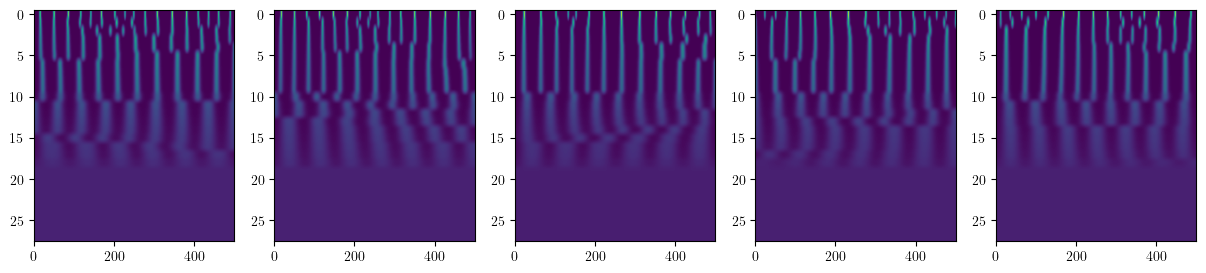

In [92]:
nrow = 1
ncol = 5
fig,axs=plt.subplots(1,5,figsize=(15,3))
for i in range(ncol):
    axs[i].imshow(concs[:,i,0,:],aspect='auto')
plt.show()

In [ ]:
pca     = PCA(n_components=2)

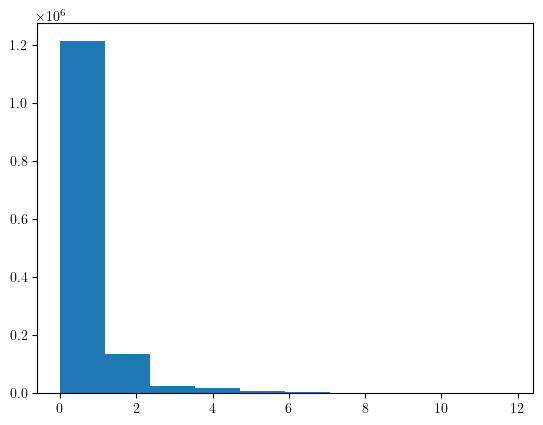

In [154]:
fig,axs=plt.subplots()
axs.hist(concs.reshape(-1))
plt.show()

In [140]:
# noise      = np.random.normal(1,0.5,size=(concs.shape))
# conc_stoch = concs + noise

In [145]:
# lscales      = np.hstack([np.arange(2,10), np.arange(10,100,10),np.arange(100,500,100)])
# da_kbin = [np.array([[[np.mean(conc_stoch[s,j,:,k:k+w], axis=1) for k in np.arange(0,ngrid-w)]
#                       for j in range(nrep)]
#                      for s in range(ndiff)]) 
#            for w in lscales]

In [72]:
#nk = np.array([x.shape[2] for x in da_kbin])

In [99]:
n = int(1e5)
nums = np.random.normal(size=n)
samp_sizes = np.array([2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000])
samp_vars = np.array([np.var(nums[np.random.choice(n,sz)]) for sz in samp_sizes])


In [120]:
nsamps = 1000
i      = 0
samp_var_mu = np.array([np.mean(np.var(nums[np.random.choice(n,size=(samp_sizes[i],nsamps))],axis=0))
                        for i in range(len(samp_sizes))])

In [146]:
samp_var_mu2 = np.array([np.mean(np.var(np.random.normal(size=(samp_sizes[i],nsamps)),axis=0))
                        for i in range(len(samp_sizes))])

In [225]:
nsamps       = 1000
samp_std_mu = np.array([np.mean(np.std(np.random.normal(size=(samp_sizes[i],nsamps)),axis=0))
                        for i in range(len(samp_sizes))])
samp_var_mu = np.array([np.mean(np.var(np.random.normal(size=(samp_sizes[i],nsamps)),axis=0))
                        for i in range(len(samp_sizes))])

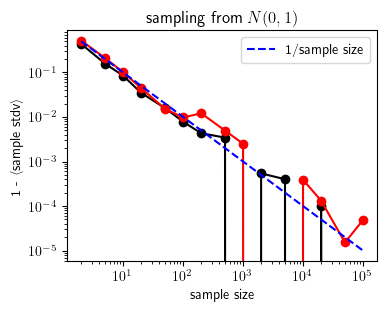

In [226]:
fig,axs=plt.subplots(figsize=(4,3))
axs.plot(samp_sizes,1-samp_std_mu,'ko-')
axs.plot(samp_sizes,1-samp_var_mu,'ro-')

axs.plot(samp_sizes, 1/samp_sizes,'b--',label=r'1/sample size')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('sample size')
axs.set_ylabel(r'1 - $\langle$sample stdv$\rangle$')
axs.set_title('sampling from $N(0,1)$')
axs.legend()
plt.show()

In [255]:
# effect of number of samples:
samp_sz     = 1000
nsamps_arr  = np.array([2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000])
samp_std_mu = np.array([np.mean(np.std(np.random.normal(size=(samp_sz,nsamps_arr[i])),axis=0))
                        for i in range(len(nsamps_arr))])
samp_var_mu = np.array([np.mean(np.var(np.random.normal(size=(samp_sz,nsamps_arr[i])),axis=0))
                        for i in range(len(nsamps_arr))])

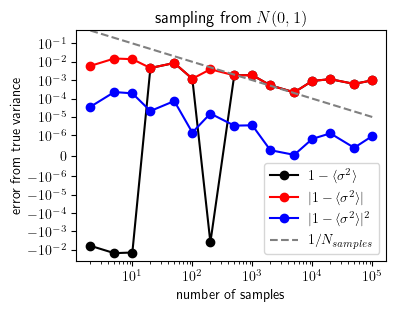

In [277]:
fig,axs=plt.subplots(figsize=(4,3))
#axs.plot(nsamps_arr,1-samp_std_mu,'ko-')
axs.plot(nsamps_arr,1-samp_var_mu,'ko-',label=r'$1-\langle \sigma^2 \rangle$')


axs.plot(nsamps_arr,np.abs(1-samp_var_mu),'ro-',label=r'$|1-\langle \sigma^2 \rangle |$')
axs.plot(nsamps_arr,np.abs(1-samp_var_mu)**2,'bo-',label=r'$|1-\langle \sigma^2 \rangle |^2$')

axs.plot(nsamps_arr, 1/nsamps_arr,'--',color='gray',label=r'$1/N_{samples}$')
axs.set_xscale('log')
axs.set_yscale('symlog', linthresh=1e-6)
axs.set_xlabel('number of samples')
axs.set_ylabel(r'error from true variance')
axs.set_title('sampling from $N(0,1)$')
axs.legend()
plt.show()

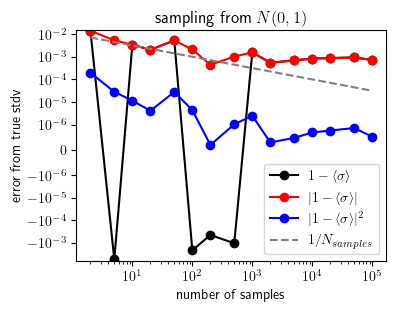

In [280]:
fig,axs=plt.subplots(figsize=(4,3))
#axs.plot(nsamps_arr,1-samp_std_mu,'ko-')
axs.plot(nsamps_arr,1-samp_std_mu,'ko-',label=r'$1-\langle \sigma \rangle$')


axs.plot(nsamps_arr,np.abs(1-samp_std_mu),'ro-',label=r'$|1-\langle \sigma \rangle |$')
axs.plot(nsamps_arr,np.abs(1-samp_std_mu)**2,'bo-',label=r'$|1-\langle \sigma \rangle |^2$')

axs.plot(nsamps_arr, 0.01/nsamps_arr**0.5,'--',color='gray',label=r'$1/N_{samples}$')
axs.set_xscale('log')
axs.set_yscale('symlog', linthresh=1e-6)
axs.set_xlabel('number of samples')
axs.set_ylabel(r'error from true stdv')
axs.set_title('sampling from $N(0,1)$')
axs.legend()
plt.show()

In [126]:
samp_var_mu2 = np.array([np.mean(np.var(np.random.normal(size=(samp_sizes[i],nsamps)),axis=0))
                        for i in range(len(samp_sizes))])

array([ 4.77014212e-01,  2.21198058e-01,  1.02396016e-01,  4.87709229e-02,
        1.91137242e-02,  1.09021890e-02, -3.88080815e-04,  6.87116492e-04,
        3.51300836e-03,  1.56183566e-04,  1.00927096e-03,  2.26319906e-03,
        8.81636079e-04,  1.00786928e-03,  1.09204946e-03])

In [210]:
nobs   = 3
nsamps = 1000
#i      = 0
# samps  = np.random.normal(size=(nsamps, samp_sizes[i],nobs))

# samp_eig0 = np.array([np.mean(np.var(np.random.normal(size=(samp_sizes[i],nsamps)),axis=0))
#                         for i in range(len(samp_sizes))])

In [211]:
samps.shape

(1000, 2, 3)

In [212]:
samp_eig0 = np.array([[PCA().fit(s).explained_variance_[0] 
                       for s in np.random.normal(size=(nsamps, samp_sizes[i],nobs))]
                      for i in range(len(samp_sizes))])

In [213]:
samp_evar0 = np.array([[PCA().fit(s).explained_variance_ratio_[0] 
                       for s in np.random.normal(size=(nsamps, samp_sizes[i],nobs))]
                      for i in range(len(samp_sizes))])

In [214]:
mu_eig0 = np.mean(samp_eig0,axis=1)
mu_evar0 = np.mean(samp_evar0,axis=1)

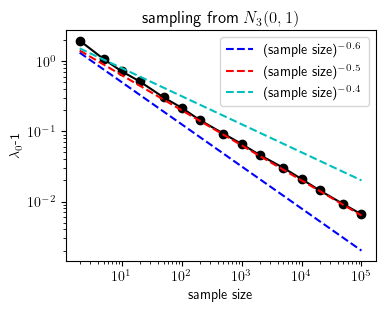

In [217]:
fig,axs=plt.subplots(figsize=(4,3))
axs.plot(samp_sizes,mu_eig0-1,'ko-')
#axs.plot(samp_sizes,mu_evar0,'ko-')

axs.plot(samp_sizes, 2*samp_sizes**-0.6,'b--',label=r'(sample size)$^{-0.6}$')
axs.plot(samp_sizes, 2*samp_sizes**-0.5,'r--',label=r'(sample size)$^{-0.5}$')
axs.plot(samp_sizes, 2*samp_sizes**-0.4,'c--',label=r'(sample size)$^{-0.4}$')


axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('sample size')
axs.set_ylabel(r'$\lambda_0$-1')
axs.set_title('sampling from $N_{0}(0,1)$'.format(nobs))
axs.legend()
plt.show()

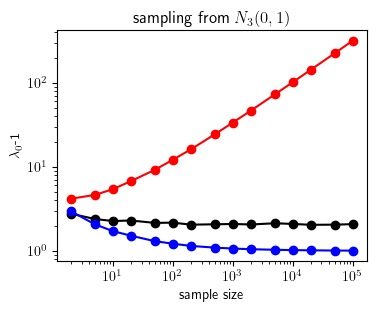

In [254]:
fig,axs=plt.subplots(figsize=(4,3))
axs.plot(samp_sizes,(mu_eig0-1)*samp_sizes**0.5,'ko-')
axs.plot(samp_sizes,mu_eig0*samp_sizes**0.5,'ro-')
axs.plot(samp_sizes,mu_eig0,'bo-')


#axs.plot(samp_sizes,mu_evar0,'ko-')

# axs.plot(samp_sizes, 2*samp_sizes**-0.6,'b--',label=r'(sample size)$^{-0.6}$')
# axs.plot(samp_sizes, 2*samp_sizes**-0.5,'r--',label=r'(sample size)$^{-0.5}$')
# axs.plot(samp_sizes, 2*samp_sizes**-0.4,'c--',label=r'(sample size)$^{-0.4}$')


axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('sample size')
axs.set_ylabel(r'$\lambda_0$-1')
axs.set_title('sampling from $N_{0}(0,1)$'.format(nobs))
#axs.legend()
plt.show()

In [301]:
nobs      = 10
samp_sz   = 1000
samp_eig0 = [[PCA().fit(s).explained_variance_[0] 
                       for s in np.random.normal(size=(nsamps_arr[i], samp_sz,nobs))]
                      for i in range(len(nsamps_arr))]

In [302]:
mu_eig0 = np.array(list(map(np.mean,samp_eig0)))

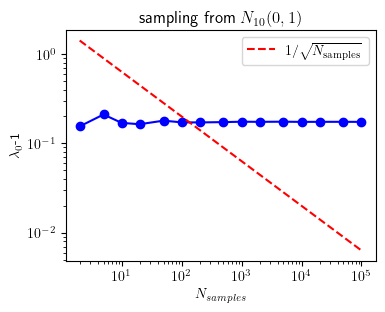

In [306]:
fig,axs=plt.subplots(figsize=(4,3))
#axs.plot(samp_sizes,(mu_eig0-1)*samp_sizes**0.5,'ko-')
#axs.plot(samp_sizes,mu_eig0*samp_sizes**0.5,'ro-')
axs.plot(samp_sizes,mu_eig0-1,'bo-')


#axs.plot(samp_sizes,mu_evar0,'ko-')

# axs.plot(samp_sizes, 2*samp_sizes**-0.6,'b--',label=r'(sample size)$^{-0.6}$')
axs.plot(samp_sizes, 2*samp_sizes**-0.5,'r--',label=r'$1/\sqrt{N_{\rm samples}}$')
# axs.plot(samp_sizes, 2*samp_sizes**-0.4,'c--',label=r'(sample size)$^{-0.4}$')


axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel('$N_{samples}$')
axs.set_ylabel(r'$\lambda_0$-1')
axs.set_title(r'sampling from $N_{0}(0,1)$'.format(nobs))
axs.legend()
plt.show()

In [97]:
nums = np.random.normal(size=n)


TypeError: 'float' object cannot be interpreted as an integer

In [91]:
sz=10
n
np.random.choice(nums,size=sz,replace=True)

ValueError: a must be 1-dimensional or an integer

In [96]:
print(np.random.normal.__doc__)


        normal(loc=0.0, scale=1.0, size=None)

        Draw random samples from a normal (Gaussian) distribution.

        The probability density function of the normal distribution, first
        derived by De Moivre and 200 years later by both Gauss and Laplace
        independently [2]_, is often called the bell curve because of
        its characteristic shape (see the example below).

        The normal distributions occurs often in nature.  For example, it
        describes the commonly occurring distribution of samples influenced
        by a large number of tiny, random disturbances, each with its own
        unique distribution [2]_.

        .. note::
            New code should use the ``normal`` method of a ``default_rng()``
            instance instead; please see the :ref:`random-quick-start`.

        Parameters
        ----------
        loc : float or array_like of floats
            Mean ("centre") of the distribution.
        scale : float or array_like of floats
 

In [227]:
np.linalg.eig(np.array([[0.5,0.5],[0.5,0.5]]))

(array([1.00000000e+00, 1.11022302e-16]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [236]:
pmat = np.array([[0.7,0.3,0],[0.6,0.3,0.1],[0.5,0,0.5]])

In [240]:
np.linalg.eig(pmat.T)

(array([1.        , 0.06972244, 0.43027756]),
 array([[-0.91630572,  0.59880267, -0.24104363],
        [-0.39270245, -0.78010553, -0.55506939],
        [-0.07854049,  0.18130286,  0.79611302]]))

In [231]:
np.linalg.inv(np.eye(2)-pmat.T)

LinAlgError: Singular matrix